# 1.0 Explore raw data and prepare songs for analysis

> **Note:** this works for the recordings of a given year only

### This notebook does the following:
 - Segments raw recordings into manually defined songs 
 > saved as new .wav files and .json files with metadata
 - Segments songs into syllables 
 > saved as on-off times in each .json file
 

In [1]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import src
import glob
import joblib
from os import fspath

import warnings
warnings.filterwarnings(action="once")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
%matplotlib inline

from src.vocalseg.dynamic_thresholding import *
from src.avgn.dataset import DataSet
from src.avgn.utils.hparams import HParams
from src.avgn.utils.paths import most_recent_subdirectory
from tqdm.autonotebook import tqdm
from src.greti.read.paths import DATA_DIR, RESOURCES_DIR
from src.greti.audio.segmentation import *
from IPython import get_ipython
from IPython.display import display, HTML, display_html

In [3]:
# Set year
year = "2020"

In [4]:
# import recorded nestboxes
files_path = DATA_DIR / "raw" / year
filelist = np.sort(list(files_path.glob("**/*.WAV")))
recorded_nestboxes = pd.DataFrame(set([file.parent.name for file in filelist]))

# import the latest brood data downloaded from https://ebmp.zoo.ox.ac.uk/broods
brood_data_path = RESOURCES_DIR / "brood_data" / year
list_of_files = glob.glob(fspath(brood_data_path) + "/*.csv")
latest_file = max(list_of_files, key=os.path.getctime)
greti_nestboxes = pd.DataFrame(
    (pd.read_csv(latest_file).query('Species == "g"').filter(["Pnum"]))["Pnum"].str[5:]
)
# get those in both lists
recorded_gretis = [
    i
    for i in recorded_nestboxes.values.tolist()
    if i in greti_nestboxes.values.tolist()
]

print("You recorded a total of " + str(len(filelist)) + " hours of audio.")
print(
    "You recorded "
    + str(len(recorded_gretis))
    + " out of a total of "
    + str(len(greti_nestboxes))
    + " great tits that bred this year"
)

You recorded a total of 42 hours of audio.
You recorded 2 out of a total of 260 great tits that bred this year


### Segment raw recordings into bouts
 - Songs manually defined in AviaNZ - for now

> `batch_segment_bouts()` usis multiprocessing. If you run into problems, use `batch_segment_bouts_single()` (much slower).

In [5]:
origin = DATA_DIR / "raw" / year # Folder to segment
DT_ID = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # Unique name for output folder
subset = "GRETI_HQ" # Name of label to select
DATASET_ID = "GRETI_HQ_2020" # Name of output dataset
threshold = 5000 # Amplitude threshold

In [6]:
batch_segment_songs(origin, DATA_DIR, DT_ID, DATASET_ID, subset=subset, threshold = threshold)

{Reading, trimming and saving songs}: 0it [00:00, ?it/s]Complete
total time (s)= 0.10953402519226074

{Reading, trimming and saving songs}: 100%|██████████| 31/31 [00:00<00:00, 8419.03it/s]
Complete
total time (s)= 91.85787463188171
{Reading, trimming and saving songs}: 100%|██████████| 41/41 [00:00<00:00, 16314.06it/s]
Complete
total time (s)= 131.51116585731506


- Let's check how many songs have been exported:

In [7]:

all_songs_path = most_recent_subdirectory(DATA_DIR / 'processed' / DATASET_ID)
all_songs_list = np.sort(list(all_songs_path.glob('**/*.wav')))
print('There are ' + str(len(all_songs_list)) + ' songs')


There are 749 songs


# Syllable segmentation

### Create dataset

In [8]:

# Dataset label
DATASET_ID = "GRETI_HQ_2020"

# datetime identifier for output folder
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

# Define parameters
hparams = HParams(
    n_fft=1024,
    win_length_ms=4,
    hop_length_ms=3,
    mel_lower_edge_hertz=1200,
    mel_upper_edge_hertz=9000,
    butter_lowcut=1200,
    butter_highcut=9000,
    ref_level_db=30,
    min_level_db=-30,
    n_jobs=-2,
    verbosity=1,
    nex=-1,
)


In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams=hparams)

# Check a sample json
dataset.sample_json

    unclosed file <_io.TextIOWrapper name='/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ_2020/2020-09-10_07-24-30/JSON/W71-GRETI_HQ-20200420_060000-8.wav.JSON' mode='r' encoding='UTF-8'>
loading json: 100%|██████████| 748/748 [00:42<00:00, 17.49it/s]
[Parallel(n_jobs=-2)]: Done 748 out of 748 | elapsed:   42.8s finished
getting unique individuals:   0%|          | 0/748 [00:00<?, ?it/s]ImportWarning:
    can't resolve package from __spec__ or __package__, falling back on __name__ and __path__


OrderedDict([('species', 'GRETI_HQ'),
             ('nestbox', 'W71'),
             ('indvs',
              OrderedDict([('W71', OrderedDict([('species', 'GRETI_HQ')]))])),
             ('recorder', '24F319045E06342B'),
             ('recordist', 'Nilo Merino Recalde'),
             ('source_datetime', '2020-04-20 06:00:00'),
             ('datetime', '2020-04-20 06:48:35.423270'),
             ('date', '2020-04-20'),
             ('time', '06:48:35.423270'),
             ('timezone', 'UTC'),
             ('samplerate_hz', 48000),
             ('length_s', 2.85225),
             ('lower_freq', 2510),
             ('upper_freq', 4461),
             ('max_amplitude', 17003.0),
             ('min_amplitude', -17898.0),
             ('bit_depth', 16),
             ('tech_comment',
              'Recorded at 06:00:00 20/04/2020 (UTC) by AudioMoth 24F319045E06342B at gain setting 3 while battery state was 3.9V.'),
             ('source_loc',
              '/home/nilomr/projects/0.0_great-tit

### Define parameters

In [31]:
# Segmentation parameters
parameters = {
    "n_fft": 1024,
    "hop_length_ms": 3,
    "win_length_ms": 15,
    "ref_level_db": 30,
    "pre": 0.4,
    "min_level_db": -26,
    "min_level_db_floor": -20,
    "db_delta": 7,
    "silence_threshold": 0.2,
    "min_silence_for_spec": 0.001,
    "max_vocal_for_spec": (0.4,),
    "min_syllable_length_s": 0.03,
    "spectral_range": [1200, 9000],
}

# There needs to be a silence of at least min_silence_for_spec length,
# and a syllable no longer than max_vocal_for_spec length

### Check a sample song

    unclosed file <_io.BufferedReader name=51>
    unclosed file <_io.BufferedReader name=53>


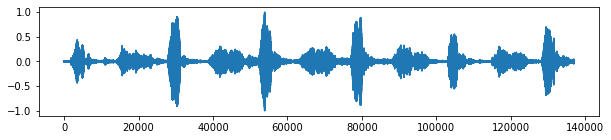

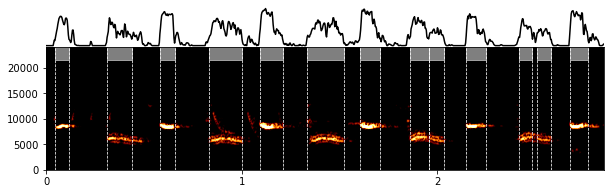

In [32]:
rate, data = load_wav(dataset.sample_json["wav_loc"])
butter_min = dataset.sample_json["lower_freq"]
butter_max = dataset.sample_json["upper_freq"]
data = butter_bandpass_filter(data, butter_min, butter_max, rate)
data = librosa.util.normalize(data)

plt.figure(figsize=(10.05, 2))
plt.plot(data)

results = dynamic_threshold_segmentation(data, rate, **parameters)

plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms=3,
    rate=rate,
    figsize=(10, 3),
)

plt.show()

### Test segmentation in a subset of the data

files:   0%|          | 0/15 [00:00<?, ?it/s]MP58
    unclosed file <_io.BufferedReader name=51>
    unclosed file <_io.BufferedReader name=53>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.198
longest vocalization 0.135


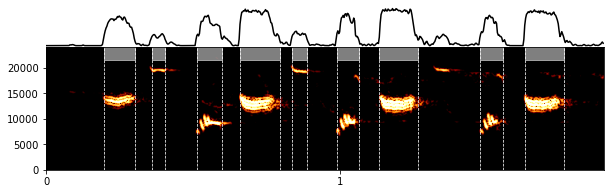


files:   7%|▋         | 1/15 [00:00<00:09,  1.43it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.14700000000000002
longest vocalization 0.17100000000000004


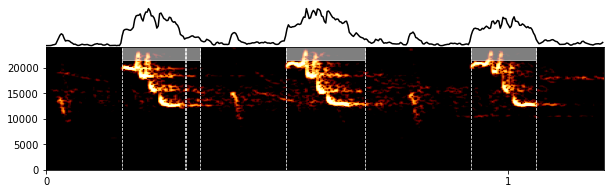


files:  13%|█▎        | 2/15 [00:01<00:08,  1.46it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.138
longest vocalization 0.11100000000000002


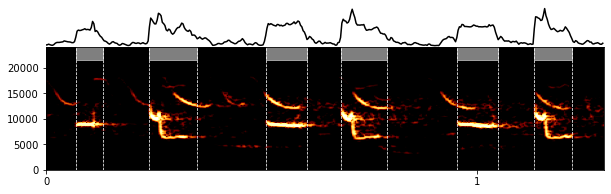


files:  20%|██        | 3/15 [00:02<00:08,  1.47it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.24900000000000003
longest vocalization 0.135


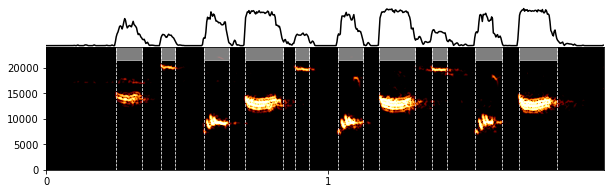


files:  27%|██▋       | 4/15 [00:02<00:07,  1.46it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.17400000000000038
longest vocalization 0.15300000000000002


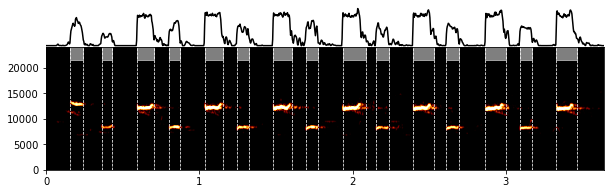


files:  33%|███▎      | 5/15 [00:03<00:07,  1.39it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.117
longest vocalization 0.10799999999999998


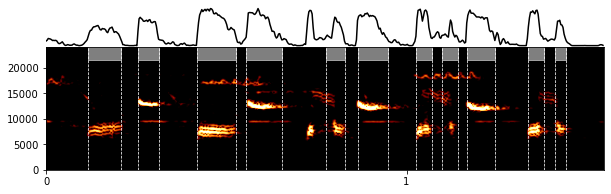


files:  40%|████      | 6/15 [00:04<00:06,  1.40it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.042
longest vocalization 0.11100000000000002


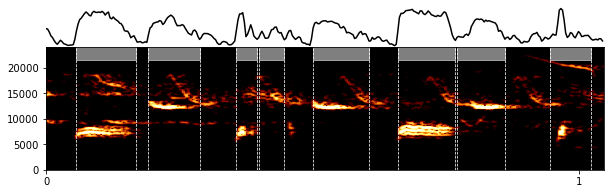


files:  47%|████▋     | 7/15 [00:04<00:05,  1.40it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15899999999999997
longest vocalization 0.1080000000000001


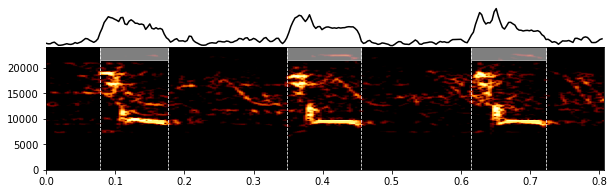


files:  53%|█████▎    | 8/15 [00:05<00:05,  1.36it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15900000000000003
longest vocalization 0.12


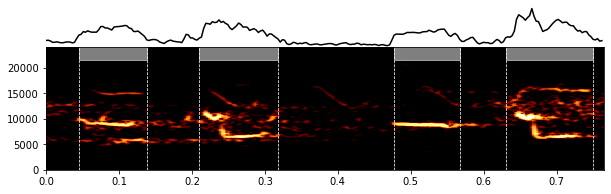


files:  60%|██████    | 9/15 [00:06<00:04,  1.34it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.07800000000000007
longest vocalization 0.09899999999999998


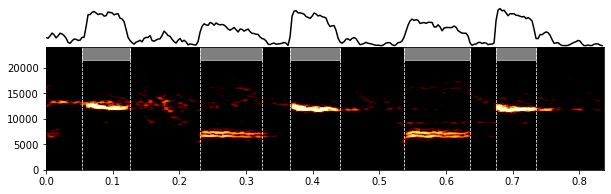


files:  67%|██████▋   | 10/15 [00:07<00:03,  1.32it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.09299999999999997
longest vocalization 0.129


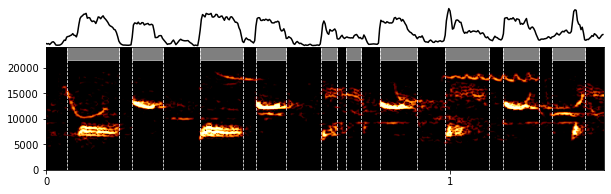


files:  73%|███████▎  | 11/15 [00:08<00:02,  1.33it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.129
longest vocalization 0.123


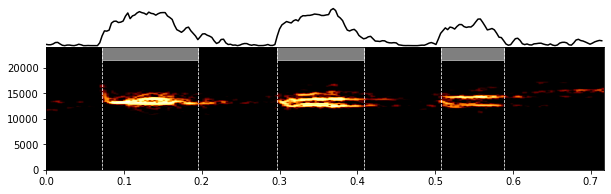


files:  80%|████████  | 12/15 [00:08<00:02,  1.24it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.19800000000000006
longest vocalization 0.171


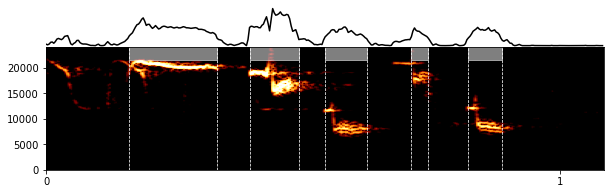


files:  87%|████████▋ | 13/15 [00:09<00:01,  1.27it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.195
longest vocalization 0.129


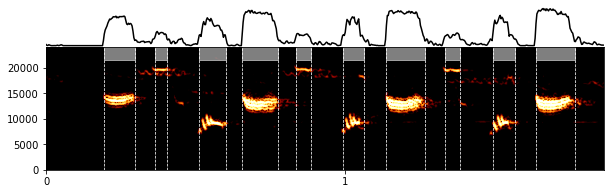


files:  93%|█████████▎| 14/15 [00:10<00:00,  1.28it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.177
longest vocalization 0.096


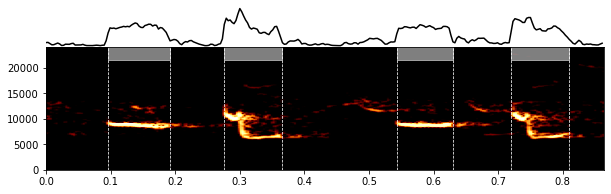


files:   0%|          | 0/15 [00:00<?, ?it/s]W71
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15
longest vocalization 0.21300000000000008


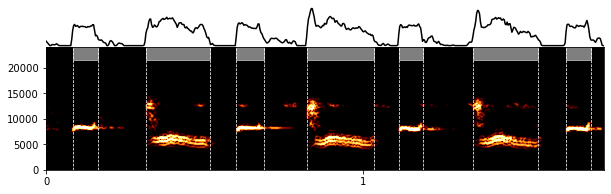


files:   7%|▋         | 1/15 [00:00<00:11,  1.26it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.198
longest vocalization 0.11699999999999999


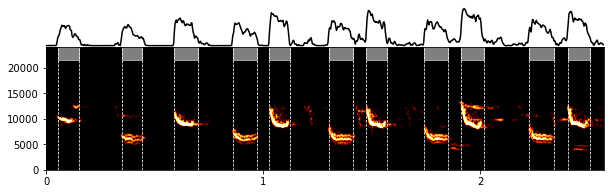


files:  13%|█▎        | 2/15 [00:01<00:10,  1.20it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.18
longest vocalization 0.18599999999999994


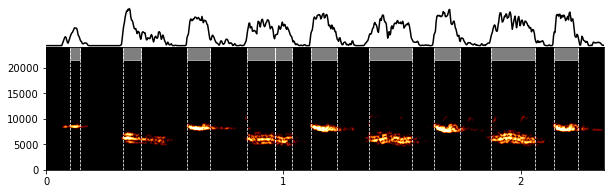


files:  20%|██        | 3/15 [00:02<00:10,  1.17it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.213
longest vocalization 0.11099999999999999


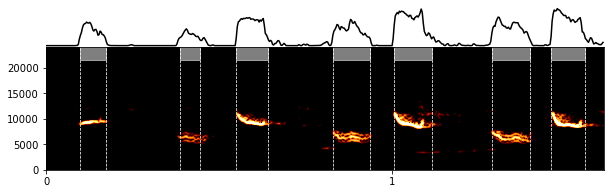


files:  27%|██▋       | 4/15 [00:03<00:09,  1.20it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.1589999999999998
longest vocalization 0.20700000000000007


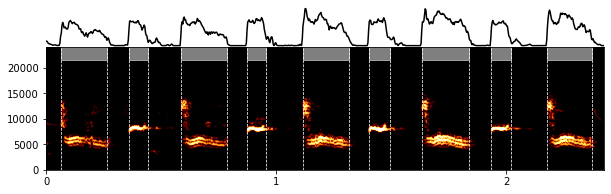


files:  33%|███▎      | 5/15 [00:04<00:08,  1.22it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.17700000000000005
longest vocalization 0.1050000000000002


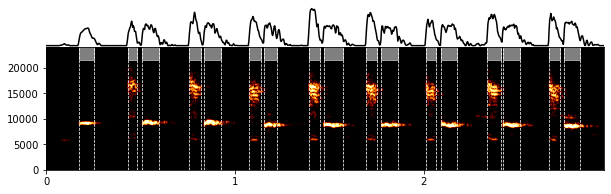


files:  40%|████      | 6/15 [00:05<00:07,  1.19it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15900000000000003
longest vocalization 0.18300000000000005


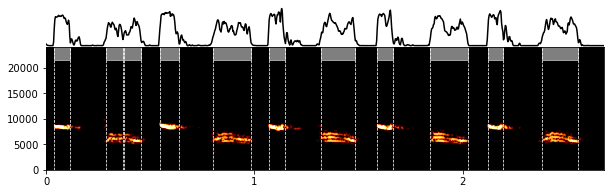


files:  47%|████▋     | 7/15 [00:05<00:06,  1.20it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.1379999999999999
longest vocalization 0.19800000000000018


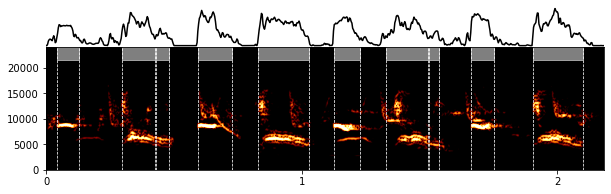


files:  53%|█████▎    | 8/15 [00:06<00:05,  1.19it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15900000000000003
longest vocalization 0.20400000000000018


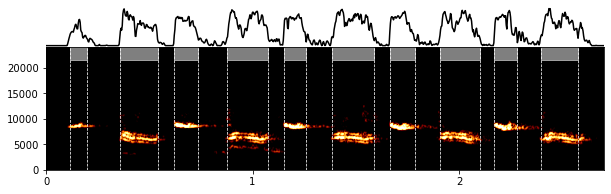


files:  60%|██████    | 9/15 [00:07<00:05,  1.18it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.15600000000000014
longest vocalization 0.10199999999999998


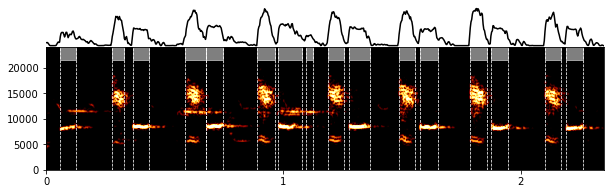


files:  67%|██████▋   | 10/15 [00:08<00:04,  1.08it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.13499999999999995
longest vocalization 0.20700000000000002


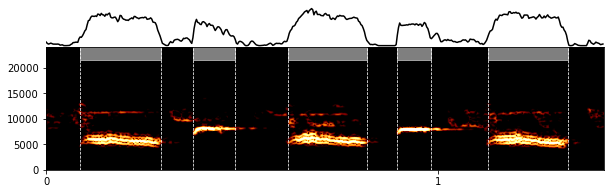


files:  73%|███████▎  | 11/15 [00:09<00:03,  1.14it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.144
longest vocalization 0.10200000000000009


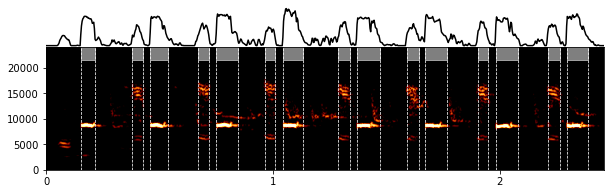


files:  80%|████████  | 12/15 [00:10<00:02,  1.13it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.14700000000000024
longest vocalization 0.18899999999999983


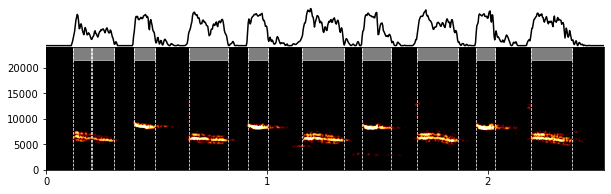


files:  87%|████████▋ | 13/15 [00:11<00:01,  1.12it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.135
longest vocalization 0.17099999999999999


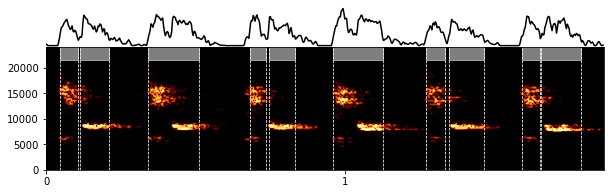


files:  93%|█████████▎| 14/15 [00:12<00:00,  1.13it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=50>
    unclosed file <_io.BufferedReader name=52>


  0%|          | 0/1 [00:00<?, ?it/s]

longest silence 0.159
longest vocalization 0.20400000000000007


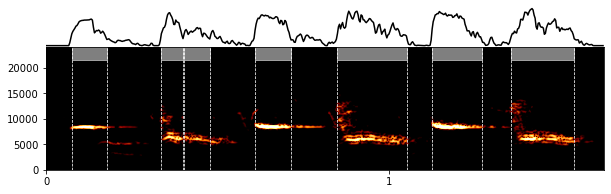


individuals: 100%|██████████| 2/2 [00:24<00:00, 12.11s/it]


In [33]:

indvs = np.array(["_".join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][55:70]

    joblib.Parallel(n_jobs=1, verbose=0)(
        joblib.delayed(segment_spec_custom)(
            key, dataset.data_files[key], **parameters, DT_ID=DT_ID, DATASET_ID=DATASET_ID, plot=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

### Segment full dataset

In [34]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=-2, verbose=1)(
        joblib.delayed(segment_spec_custom)(
            key, 
            dataset.data_files[key], 
            **parameters,
            DT_ID=DT_ID, 
            DATASET_ID=DATASET_ID, 
            save=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

files:   0%|          | 0/335 [00:00<?, ?it/s]MP58
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.

files:  13%|█▎        | 42/335 [00:06<00:31,  9.31it/s][Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.8s

files:  59%|█████▊    | 196/335 [00:19<00:11, 11.73it/s][Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   19.2s

files:  98%|█████████▊| 329/335 [00:29<00:00, 11.69it/s]
[Parallel(n_jobs=-2)]: Done 335 out of 335 | elapsed:   31.2s finished
files:   0%|          | 0/413 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
W71

files:  10%|█         | 42/413 [00:02<00:25, 14.69it/s][Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.1s

files:  47%|████▋     | 196/413 [00:15<00:17, 12.17it/s][Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   16.1s

files: 100%|██████████| 413/413 [00:34<00:00, 11.29it/s]
[Parallel(n_jobs=-2)]: Done 413 out of 413 | elapsed:   36.2s finished
individuals: 10